In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    fbeta_score,
    f1_score,
    make_scorer,
    accuracy_score,
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
feat_30_loc = "../data/features_30_sec.csv"
feat_3_loc = "../data/features_3_sec.csv"
# named long and short to differentiate easier
long = pd.read_csv(feat_30_loc)
short = pd.read_csv(feat_3_loc)

long_og = long.copy()
short_og = short.copy()

<IPython.core.display.Javascript object>

In [5]:
var_cols = short.columns[short.columns.str.contains("_var")]
logged_var_long_df = long.copy()
logged_var_short_df = short.copy()
for col in var_cols:
    logged_var_long_df[col + "_logged"] = np.log(logged_var_long_df[col])
    logged_var_long_df = logged_var_long_df.drop(col, 1)
    logged_var_short_df[col + "_logged"] = np.log(logged_var_short_df[col])
    logged_var_short_df = logged_var_short_df.drop(col, 1)

<IPython.core.display.Javascript object>

In [6]:
long_X = logged_var_long_df.drop("label", 1)
long_y = logged_var_long_df["label"]

long_X_train, long_X_test, long_y_train, long_y_test = train_test_split(
    long_X, long_y, test_size=0.2, random_state=34, stratify=long_y
)

<IPython.core.display.Javascript object>

In [7]:
files_stripped = long_X_train["filename"].str.strip(".wav")
short_train_df = logged_var_short_df[
    logged_var_short_df["filename"].str.slice(0, -6).isin(list(files_stripped))
]
short_train_df.head(10)

,filename,length,chroma_stft_mean,rms_mean,spectral_centroid_mean,spectral_bandwidth_mean,rolloff_mean,zero_crossing_rate_mean,harmony_mean,perceptr_mean,...,mfcc11_var_logged,mfcc12_var_logged,mfcc13_var_logged,mfcc14_var_logged,mfcc15_var_logged,mfcc16_var_logged,mfcc17_var_logged,mfcc18_var_logged,mfcc19_var_logged,mfcc20_var_logged
0,blues.00000.0.wav,66149,0.335406,0.130405,1773.065032,1972.744388,3714.560359,0.081851,-0.000078,-0.000068,...,4.199753,3.808962,3.531333,3.876799,3.755859,3.681027,3.596990,3.640192,3.515064,3.778989
1,blues.00000.1.wav,66149,0.343065,0.112699,1816.693777,2010.051501,3869.682242,0.087173,-0.000099,-0.000103,...,3.995884,3.705316,3.427791,3.887407,4.228071,4.170507,3.705679,3.936991,4.575029,4.093395
2,blues.00000.2.wav,66149,0.346815,0.132003,1788.539719,2084.565132,3997.639160,0.071383,-0.000066,0.000065,...,3.869358,3.599226,3.706844,3.423834,3.918273,4.209703,3.344577,3.822484,3.971251,3.499688
3,blues.00000.3.wav,66149,0.363639,0.132565,1655.289045,1960.039988,3568.300218,0.069426,-0.000014,0.000018,...,4.069718,3.666174,4.106187,3.699115,3.799220,3.865758,3.344173,3.548782,3.928609,3.466476
4,blues.00000.4.wav,66149,0.335579,0.143289,1630.656199,1948.503884,3469.992864,0.070095,0.000041,-0.000106,...,4.007883,3.766533,3.839780,3.217123,3.684292,3.412347,3.826049,3.938929,3.286115,3.372341
5,blues.00000.5.wav,66149,0.376670,0.132618,1994.915219,2152.767854,4371.985614,0.092420,-0.000039,-0.000254,...,3.651722,3.424630,3.641021,3.387925,3.071240,3.448338,3.534683,3.708464,3.479944,3.363589
6,blues.00000.6.wav,66149,0.379909,0.130335,1962.150096,2146.503479,4325.026668,0.089573,-0.000053,0.000214,...,4.385335,3.827220,3.729863,3.872221,3.333365,3.525009,3.243516,3.870319,3.673315,3.258063
7,blues.00000.7.wav,66149,0.331880,0.140600,1701.890924,1979.387612,3625.280386,0.070936,0.000019,-0.000090,...,3.921640,3.932056,3.683036,3.505163,3.805174,3.649520,3.199909,3.285268,3.142013,3.749809
8,blues.00000.8.wav,66149,0.347877,0.133130,1746.473502,1887.619723,3586.934721,0.087669,-0.000081,-0.000059,...,3.966541,3.429400,3.616207,3.869016,4.068214,3.791243,3.396961,3.521737,4.392130,4.581070
9,blues.00000.9.wav,66149,0.358061,0.115312,1763.948942,1874.195710,3505.522649,0.101777,-0.000117,0.000166,...,4.105441,4.170912,3.300678,3.702551,3.922384,3.783458,3.885103,3.733842,4.566987,3.699236


<IPython.core.display.Javascript object>

In [8]:
files_stripped = long_X_test["filename"].str.strip(".wav")
short_test_df = logged_var_short_df[
    logged_var_short_df["filename"].str.slice(0, -6).isin(list(files_stripped))
]
short_test_df

,filename,length,chroma_stft_mean,rms_mean,spectral_centroid_mean,spectral_bandwidth_mean,rolloff_mean,zero_crossing_rate_mean,harmony_mean,perceptr_mean,...,mfcc11_var_logged,mfcc12_var_logged,mfcc13_var_logged,mfcc14_var_logged,mfcc15_var_logged,mfcc16_var_logged,mfcc17_var_logged,mfcc18_var_logged,mfcc19_var_logged,mfcc20_var_logged
50,blues.00005.0.wav,66149,0.302958,0.074403,1148.336755,1481.481546,2285.749512,0.049448,-0.000021,-0.000021,...,3.129887,4.317805,3.868644,3.198746,3.220440,3.638702,2.955164,3.163215,3.462902,3.156687
51,blues.00005.1.wav,66149,0.325506,0.080293,1210.571572,1424.920044,2228.934983,0.057752,0.000025,-0.000009,...,3.874508,3.669179,3.952440,3.325389,2.593266,3.462044,3.741462,3.500137,2.721179,3.418986
52,blues.00005.2.wav,66149,0.299864,0.156715,3191.200301,2190.240135,5734.540452,0.190655,-0.000002,-0.000026,...,4.811318,4.949066,4.504757,4.642990,5.082304,4.432605,4.186323,4.351435,3.565979,4.315627
53,blues.00005.3.wav,66149,0.299961,0.124830,2124.493966,1771.906237,3852.538499,0.121161,0.000025,-0.000017,...,3.871562,4.349438,4.354326,3.760185,4.023502,4.525363,4.240223,4.191362,3.508737,3.779347
54,blues.00005.4.wav,66149,0.323245,0.073035,2446.168018,2092.543627,4750.638709,0.114742,-0.000025,-0.000051,...,5.086935,4.709287,4.623443,3.945663,5.041515,4.050801,4.139557,3.832766,3.993757,3.859010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66149,0.349126,0.050019,1499.083005,1718.707215,3015.559458,0.072885,-0.000034,-0.000020,...,3.416803,3.839206,3.935643,3.410298,4.386414,3.749174,3.646150,3.435594,3.887814,3.662714
9986,rock.00099.6.wav,66149,0.372564,0.057897,1847.965128,1906.468492,3746.694524,0.089111,-0.000027,-0.000045,...,3.501858,3.690007,3.688708,3.818595,3.533665,3.478628,4.195977,3.996626,4.150288,2.928365
9987,rock.00099.7.wav,66149,0.347481,0.052403,1346.157659,1561.859087,2442.362154,0.072194,0.000015,-0.000029,...,4.520072,3.518154,3.361223,4.594477,3.787080,4.359630,3.080946,3.257359,3.883261,3.727787
9988,rock.00099.8.wav,66149,0.387527,0.066430,2084.515327,2018.366254,4313.266226,0.104072,0.000004,-0.000048,...,3.353508,3.200891,2.922559,2.939444,3.026968,3.343700,2.845487,3.065395,3.212601,2.548488


<IPython.core.display.Javascript object>

In [9]:
m_start = 20  # highest mfcc to use. higher than this is too high in the frequency spectrum to really matter
mel_freq_drops = [f"mfcc{x}_mean" for x in range(m_start, 21)] + [
    f"mfcc{x}_var_logged" for x in range(m_start, 21)
]

<IPython.core.display.Javascript object>

In [10]:
# best balance for VIF I could tune
drop_cols = [
    "length",
    "filename",
    "label",
    "zero_crossing_rate_mean",
    "zero_crossing_rate_var_logged",
    "rolloff_mean",
    #     "harmony_var_logged",
    "rolloff_var_logged",
    "spectral_centroid_var_logged",
    "spectral_bandwidth_var_logged",
    "spectral_centroid_mean",
    "spectral_bandwidth_mean",
    "rms_mean",
    "rms_var_logged",
    #     "chroma_stft_mean",
    #     "chroma_stft_var_logged",
    #     "harmony_mean",
    #     "perceptr_mean",
    #     "perceptr_var_logged",
    #     "tempo",
    "mfcc1_mean",
    #         "mfcc2_mean",
]
drop_cols = drop_cols + mel_freq_drops
print_vif(logged_var_short_df.drop(drop_cols, 1,))

VIF results
-------------------------------
const                     1438.405549
chroma_stft_mean             4.100246
harmony_mean                 1.486555
perceptr_mean                1.581305
tempo                        1.009483
mfcc2_mean                   2.201447
mfcc3_mean                   1.946986
mfcc4_mean                   2.065740
mfcc5_mean                   2.706351
mfcc6_mean                   3.426515
mfcc7_mean                   3.244584
mfcc8_mean                   3.969889
mfcc9_mean                   2.821545
mfcc10_mean                  3.054599
mfcc11_mean                  2.446155
mfcc12_mean                  2.877017
mfcc13_mean                  2.733941
mfcc14_mean                  2.321133
mfcc15_mean                  2.528026
mfcc16_mean                  2.219810
mfcc17_mean                  2.278150
mfcc18_mean                  2.058928
mfcc19_mean                  1.615415
chroma_stft_var_logged       2.293189
harmony_var_logged           3.227920
percep

<IPython.core.display.Javascript object>

In [11]:
X_train = short_train_df.drop(drop_cols, 1)
X_test = short_test_df.drop(drop_cols, 1)
y_train = short_train_df["label"]
y_test = short_test_df["label"]

<IPython.core.display.Javascript object>

In [12]:
num_cols = list(X_train.columns)

bin_cols = []

cat_cols = []
drop_cats = []


preprocessing = ColumnTransformer(
    [
        # Scale numeric columns (not needed for all models but can't hurt)
        ("scaler", StandardScaler(), num_cols)
    ],
    remainder="passthrough",
)


pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        #         ("pca", PCA(n_components=8)),
        # Choose your model and put it here
        ("svc", SVC()),
    ]
)


params = {
    # Use model__ with hyperprammeter names after
    "svc__C": [1, 10],
    "svc__kernel": ["linear", "rbf", "poly"],
    "svc__decision_function_shape": ["ovo", "ovr"],
    "svc__degree": [2, 3, 5],
}


pipeline_cv = GridSearchCV(pipeline, params, verbose=1, n_jobs=-1, cv=2)

pipeline_cv.fit(X_train, y=y_train)


print(pipeline_cv.score(X_train, y_train))
print(pipeline_cv.score(X_test, y_test))
pipeline_cv.best_params_

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   20.4s finished


0.9997496871088861
0.7325


{'svc__C': 10,
 'svc__decision_function_shape': 'ovo',
 'svc__degree': 2,
 'svc__kernel': 'rbf'}

<IPython.core.display.Javascript object>

scaler_train = StandardScaler()
scaler_test = StandardScaler()

scaler_train.fit(X_train)
scaler_test.fit(X_test)

scaled_X_train = scaler_train.transform(X_train)
scaled_X_test = scaler_test.transform(X_test)

model = SVC(C=10, kernel="linear", decision_function_shape="ovo")
model.fit(scaled_X_train, y_train)



print(model.score(scaled_X_train, y_train))
print(model.score(scaled_X_test, y_test))

In [ ]:
num_cols = list(X_train.columns)

bin_cols = []

cat_cols = []
drop_cats = []


preprocessing = ColumnTransformer(
    [
        # Scale numeric columns (not needed for all models but can't hurt)
        ("scaler", StandardScaler(), num_cols)
    ],
    remainder="passthrough",
)


pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        # ("pca", PCA()),
        # Choose your model and put it here
        ("knn", KNeighborsClassifier()),
        # ("rfc", RandomForestClassifier()),
    ]
)


params = {
    "knn__n_neighbors": [3000],
    "knn__weights": ["distance"],
    "knn__leaf_size": [30],
    "knn__algorithm": ["kd_tree", "ball_tree"],
}

# params = {
#     # Use model__ with hyperprammeter names after
#     "rfc__criterion": ["gini", "entropy"],
#     "rfc__max_depth": [10, 14, 20],
#     "rfc__min_samples_leaf": [10, 16, 20],
# }
# n_trees = 200
# pipeline["rfc"].n_estimators = n_trees

pipeline_cv = GridSearchCV(pipeline, params, verbose=1, n_jobs=-1, cv=5)

pipeline_cv.fit(X_train, y=y_train)


print(pipeline_cv.score(X_train, y_train))
print(pipeline_cv.score(X_test, y_test))
pipeline_cv.best_params_

all_feat_cols = list(short_train_df.columns[3:])
all_feat_cols.remove("label")

In [13]:
num_cols = list(X_train.columns)

bin_cols = []

cat_cols = []
drop_cats = []


preprocessing = ColumnTransformer(
    [
        # Scale numeric columns (not needed for all models but can't hurt)
        ("scaler", StandardScaler(), num_cols)
    ],
    remainder="passthrough",
)


pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        # Choose your model and put it here
        ("xgb", XGBClassifier()),
    ]
)


params = {
    "xgb__subsample": [0.5, 0.75, 1.0],
    "xgb__colsample_bytree": [0.4, 0.6, 0.8, 1.0],
    "xgb__max_depth": [6, 8, 10],
}

n_trees = 100
learning_rate = 10 / n_trees

pipeline["xgb"].n_estimators = n_trees
pipeline["xgb"].learning_rate = learning_rate

scaler = pipeline.named_steps["preprocessing"]
scaler.fit(X_train)
X_test_scaled = scaler.transform(X_test)


pipeline_cv = GridSearchCV(pipeline, params, verbose=1, n_jobs=-1, cv=2)

pipeline_cv.fit(X_train, y=y_train, xgb__eval_set=[(X_test_scaled, y_test)])


print(pipeline_cv.score(X_train, y_train))
print(pipeline_cv.score(X_test, y_test))
pipeline_cv.best_params_

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.4min


[0]	validation_0-merror:0.50200


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  3.3min finished


[1]	validation_0-merror:0.44400
[2]	validation_0-merror:0.40200
[3]	validation_0-merror:0.38150
[4]	validation_0-merror:0.36500
[5]	validation_0-merror:0.34600
[6]	validation_0-merror:0.34500
[7]	validation_0-merror:0.33500
[8]	validation_0-merror:0.32900
[9]	validation_0-merror:0.32300
[10]	validation_0-merror:0.31950
[11]	validation_0-merror:0.31750
[12]	validation_0-merror:0.30800
[13]	validation_0-merror:0.30950
[14]	validation_0-merror:0.30650
[15]	validation_0-merror:0.30650
[16]	validation_0-merror:0.30550
[17]	validation_0-merror:0.29750
[18]	validation_0-merror:0.29900
[19]	validation_0-merror:0.29750
[20]	validation_0-merror:0.29250
[21]	validation_0-merror:0.29200
[22]	validation_0-merror:0.29850
[23]	validation_0-merror:0.29900
[24]	validation_0-merror:0.29600
[25]	validation_0-merror:0.29450
[26]	validation_0-merror:0.29300
[27]	validation_0-merror:0.29350
[28]	validation_0-merror:0.29300
[29]	validation_0-merror:0.29400
[30]	validation_0-merror:0.28900
[31]	validation_0-m

{'xgb__colsample_bytree': 0.6, 'xgb__max_depth': 10, 'xgb__subsample': 0.5}

<IPython.core.display.Javascript object>

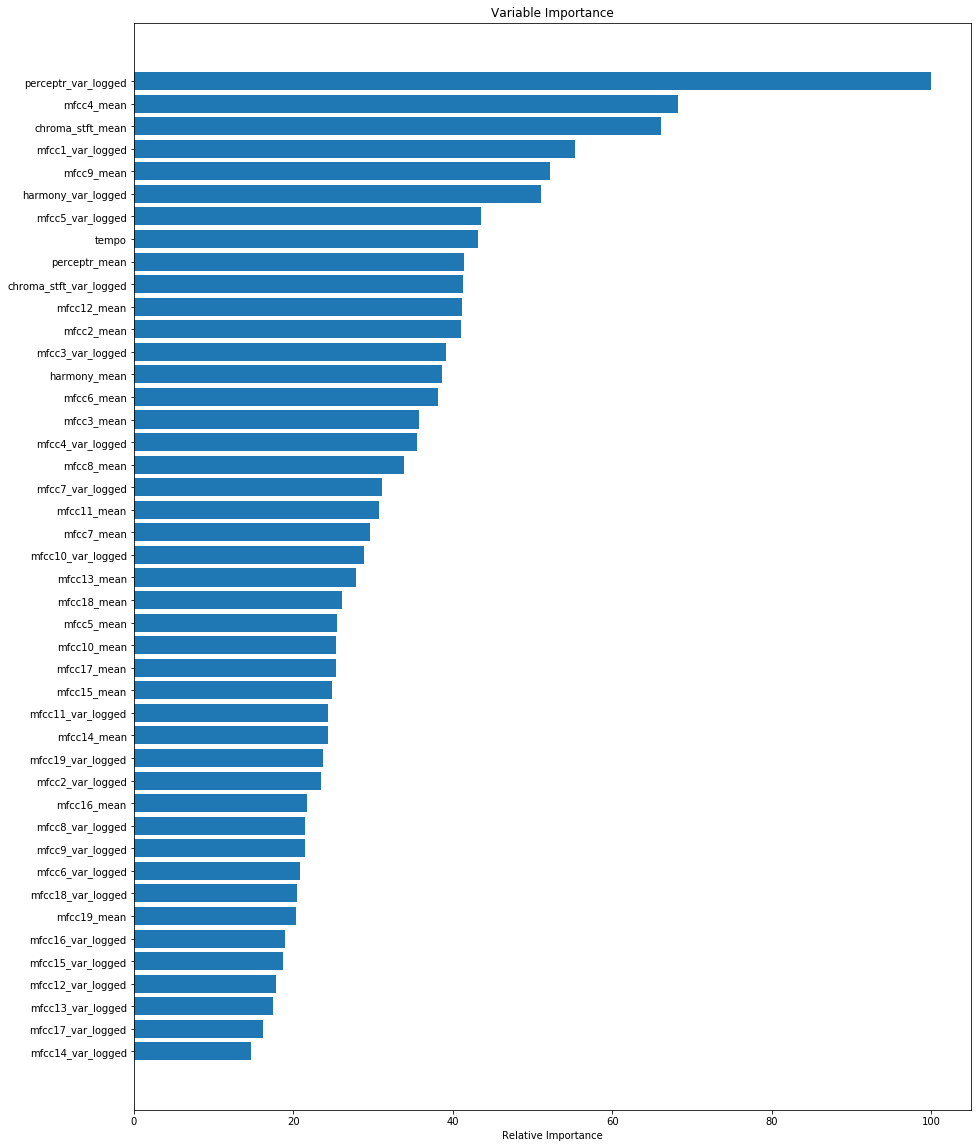

<IPython.core.display.Javascript object>

In [14]:
feature_importance = pipeline_cv.best_estimator_.named_steps["xgb"].feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5


plt.figure(figsize=(15, 20))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

In [15]:
y_pred = pipeline_cv.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[156   0  11   0   0  18   6   0   5   4]
 [  0 191   0   0   0   8   0   0   0   1]
 [ 11   1 156   6   0   8   5   2   2   9]
 [  4   0  10 142  15   0   0  17   7   5]
 [  0   0   4  25 109   0   9  24  26   3]
 [  1  31  23   0   0 134   0   4   0   7]
 [  4   0   0   7   8   0 169   0   1  11]
 [  0   1   6   4   4   5   0 165   4  11]
 [  3   0  28  14   8   0   3   4 132   8]
 [  2   4  20  28   4  15  15  10   9  93]]
              precision    recall  f1-score   support

       blues       0.86      0.78      0.82       200
   classical       0.84      0.95      0.89       200
     country       0.60      0.78      0.68       200
       disco       0.63      0.71      0.67       200
      hiphop       0.74      0.55      0.63       200
        jazz       0.71      0.67      0.69       200
       metal       0.82      0.84      0.83       200
         pop       0.73      0.82      0.77       200
      reggae       0.71      0.66      0.68       200
        rock       0.61     

<IPython.core.display.Javascript object>

In [16]:
short["predicted"] = pipeline_cv.predict(logged_var_short_df.drop(drop_cols, 1))

<IPython.core.display.Javascript object>

In [17]:
long["vote_pred"] = "none"

for i in range(long["filename"].size):
    curr_file = long["filename"][i]
    file_stripped = curr_file.strip(".wav")
    sub_selection = short["filename"].str.contains(file_stripped)
    prediction = (
        short[sub_selection]["predicted"]
        .value_counts()
        .sort_values(ascending=False)
        .index[0]
    )
    long["vote_pred"][i] = prediction

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


<IPython.core.display.Javascript object>

In [18]:
print(confusion_matrix(long["label"], long["vote_pred"]))
print(classification_report(long["label"], long["vote_pred"]))

[[98  0  0  0  0  1  1  0  0  0]
 [ 0 99  0  0  0  1  0  0  0  0]
 [ 0  0 99  0  0  0  1  0  0  0]
 [ 0  0  1 95  2  0  0  2  0  0]
 [ 0  0  0  2 91  0  2  3  2  0]
 [ 0  3  2  0  0 95  0  0  0  0]
 [ 0  0  0  1  1  0 97  0  0  1]
 [ 0  0  1  0  0  0  0 97  0  2]
 [ 0  0  3  1  1  0  0  0 94  1]
 [ 0  0  2  1  0  2  0  1  1 93]]
              precision    recall  f1-score   support

       blues       1.00      0.98      0.99       100
   classical       0.97      0.99      0.98       100
     country       0.92      0.99      0.95       100
       disco       0.95      0.95      0.95       100
      hiphop       0.96      0.91      0.93       100
        jazz       0.96      0.95      0.95       100
       metal       0.96      0.97      0.97       100
         pop       0.94      0.97      0.96       100
      reggae       0.97      0.94      0.95       100
        rock       0.96      0.93      0.94       100

    accuracy                           0.96      1000
   macro avg       

<IPython.core.display.Javascript object>

In [19]:
long_pred_df = logged_var_long_df.drop(drop_cols, 1)
# long_pred_df = scaler.transform(long_pred_df)
long["model_pred"] = pipeline_cv.predict(long_pred_df)

<IPython.core.display.Javascript object>

In [20]:
print(confusion_matrix(long["label"], long["model_pred"]))
print(classification_report(long["label"], long["model_pred"]))

[[95  0  1  1  0  0  0  0  3  0]
 [ 0 94  1  0  0  4  0  0  1  0]
 [ 1  0 94  1  0  0  0  0  4  0]
 [ 0  0  1 93  2  0  0  2  2  0]
 [ 1  0  0  3 90  0  0  3  3  0]
 [ 2  2  4  0  0 91  0  1  0  0]
 [ 1  0  1  2  0  0 95  0  0  1]
 [ 0  0  1  1  1  0  0 94  2  1]
 [ 0  0  3  2  1  0  0  1 93  0]
 [ 0  0  8  3  1  0  0  2  5 81]]
              precision    recall  f1-score   support

       blues       0.95      0.95      0.95       100
   classical       0.98      0.94      0.96       100
     country       0.82      0.94      0.88       100
       disco       0.88      0.93      0.90       100
      hiphop       0.95      0.90      0.92       100
        jazz       0.96      0.91      0.93       100
       metal       1.00      0.95      0.97       100
         pop       0.91      0.94      0.93       100
      reggae       0.82      0.93      0.87       100
        rock       0.98      0.81      0.89       100

    accuracy                           0.92      1000
   macro avg       

<IPython.core.display.Javascript object>

In [21]:
drop_cols_copy = drop_cols.copy()
drop_cols_copy.remove("label")
long_y_pred = pipeline_cv.predict(long_X_test.drop(drop_cols_copy, 1))

<IPython.core.display.Javascript object>

In [22]:
# model prediction on original train test split on the long df training
pipeline_cv.score(long_X_train.drop(drop_cols_copy, 1), long_y_train)

0.96375

<IPython.core.display.Javascript object>

In [23]:
# model prediction on original train test split on the long df testing
pipeline_cv.score(long_X_test.drop(drop_cols_copy, 1), long_y_test)

0.745

<IPython.core.display.Javascript object>

In [24]:
long_y_pred
print(confusion_matrix(long_y_test, long_y_pred))
print(classification_report(long_y_test, long_y_pred))

[[18  0  1  0  0  0  0  0  1  0]
 [ 0 19  0  0  0  1  0  0  0  0]
 [ 1  0 17  1  0  0  0  0  1  0]
 [ 0  0  1 14  2  0  0  2  1  0]
 [ 0  0  0  3 11  0  0  3  3  0]
 [ 0  2  3  0  0 14  0  1  0  0]
 [ 1  0  0  1  0  0 17  0  0  1]
 [ 0  0  1  1  1  0  0 15  1  1]
 [ 0  0  3  2  1  0  0  0 14  0]
 [ 0  0  4  2  1  0  0  2  1 10]]
              precision    recall  f1-score   support

       blues       0.90      0.90      0.90        20
   classical       0.90      0.95      0.93        20
     country       0.57      0.85      0.68        20
       disco       0.58      0.70      0.64        20
      hiphop       0.69      0.55      0.61        20
        jazz       0.93      0.70      0.80        20
       metal       1.00      0.85      0.92        20
         pop       0.65      0.75      0.70        20
      reggae       0.64      0.70      0.67        20
        rock       0.83      0.50      0.62        20

    accuracy                           0.74       200
   macro avg       

<IPython.core.display.Javascript object>

In [25]:
long_vote_pred = long["vote_pred"]
long_label = long["label"]

(
    long_vote_pred_train,
    long_vote_pred_test,
    long_label_train,
    long_label_test,
) = train_test_split(
    long_vote_pred, long_label, test_size=0.2, random_state=34, stratify=long_label
)

<IPython.core.display.Javascript object>

In [26]:
print(confusion_matrix(long_label_test, long_vote_pred_test))
print(classification_report(long_label_test, long_vote_pred_test))
print(accuracy_score(long_label_test, long_vote_pred_test))

[[18  0  0  0  0  1  1  0  0  0]
 [ 0 19  0  0  0  1  0  0  0  0]
 [ 0  0 19  0  0  0  1  0  0  0]
 [ 0  0  1 15  2  0  0  2  0  0]
 [ 0  0  0  2 11  0  2  3  2  0]
 [ 0  3  2  0  0 15  0  0  0  0]
 [ 0  0  0  1  1  0 17  0  0  1]
 [ 0  0  1  0  0  0  0 17  0  2]
 [ 0  0  3  1  1  0  0  0 14  1]
 [ 0  0  2  1  0  2  0  1  1 13]]
              precision    recall  f1-score   support

       blues       1.00      0.90      0.95        20
   classical       0.86      0.95      0.90        20
     country       0.68      0.95      0.79        20
       disco       0.75      0.75      0.75        20
      hiphop       0.73      0.55      0.63        20
        jazz       0.79      0.75      0.77        20
       metal       0.81      0.85      0.83        20
         pop       0.74      0.85      0.79        20
      reggae       0.82      0.70      0.76        20
        rock       0.76      0.65      0.70        20

    accuracy                           0.79       200
   macro avg       

<IPython.core.display.Javascript object>

In [27]:
# majority vote predictions on training data
print(confusion_matrix(long_label_train, long_vote_pred_train))
print(classification_report(long_label_train, long_vote_pred_train))
print(accuracy_score(long_label_train, long_vote_pred_train))

[[80  0  0  0  0  0  0  0  0  0]
 [ 0 80  0  0  0  0  0  0  0  0]
 [ 0  0 80  0  0  0  0  0  0  0]
 [ 0  0  0 80  0  0  0  0  0  0]
 [ 0  0  0  0 80  0  0  0  0  0]
 [ 0  0  0  0  0 80  0  0  0  0]
 [ 0  0  0  0  0  0 80  0  0  0]
 [ 0  0  0  0  0  0  0 80  0  0]
 [ 0  0  0  0  0  0  0  0 80  0]
 [ 0  0  0  0  0  0  0  0  0 80]]
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00        80
   classical       1.00      1.00      1.00        80
     country       1.00      1.00      1.00        80
       disco       1.00      1.00      1.00        80
      hiphop       1.00      1.00      1.00        80
        jazz       1.00      1.00      1.00        80
       metal       1.00      1.00      1.00        80
         pop       1.00      1.00      1.00        80
      reggae       1.00      1.00      1.00        80
        rock       1.00      1.00      1.00        80

    accuracy                           1.00       800
   macro avg       

<IPython.core.display.Javascript object>